<a href="https://colab.research.google.com/github/mk7890/Resume-Parsing-System/blob/main/Resume_Parsing_System_DistilBERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

1. Preprocessing

Clean the text: Remove unnecessary characters.

3. Feature Extraction
Tokenization: Split the text into individual words or tokens.
Create an annotated dataset.

4. Building the Model

Train the model on annotated resumes where entities like name, job role, etc., are labeled.

5. Model Evaluation.

6. Saving and Deployment
Save the trained model, and deploy the model using Streamlit for an interactive web application.

# Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import random
from itertools import cycle, islice

In [ ]:
from transformers import DistilBertTokenizerFast
from datasets import Dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import Trainer, TrainingArguments
from tqdm.notebook import tqdm
from transformers.trainer_callback import TrainerCallback

In [ ]:
!pip install spacy transformers pdfplumber PyMuPDF torch joblib pickle5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 885.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━

# Load Datasets

In [2]:
jobs_df = pd.read_csv('/content/jobs_sampled.csv')
jobs_df.head()

,Name,Title,Role,Contact,Qualifications,Experience,Skills,Company
0,Christopher Duffy,Back-End Developer,API Developer,922.551.4444,MBA,3 to 14 Years,API design and development RESTful API knowled...,State Farm Insurance
1,Stephanie Morris,Back-End Developer,API Developer,806.716.2250x944,BA,5 to 14 Years,API design and development RESTful API knowled...,Capital One Financial
2,Anthony Taylor,Back-End Developer,API Developer,(953)310-0075x7268,B.Com,4 to 13 Years,API design and development RESTful API knowled...,Cummins
3,Jacqueline Anderson,Back-End Developer,API Developer,+1-923-200-8008,MBA,5 to 8 Years,API design and development RESTful API knowled...,Eastman Chemical
4,Angela Hall,Back-End Developer,API Developer,(246)327-9483,M.Com,3 to 15 Years,API design and development RESTful API knowled...,Analog Devices


In [4]:
import pandas as pd

# Step 1: Read the text file
file_path = "/content/job roles and skills.txt"
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Step 2: Process the header
original_header = lines[0].strip().split(',')
new_headers = [original_header[0], 'Skills']  # Rename "Relevant Skills" to "Skills"

# Step 3: Process each data row
data = []
for line in lines[1:]:
    line = line.strip()
    if not line:
        continue  # Skip empty lines
    parts = line.split(',', 1)  # Split at the first comma
    job_role = parts[0]
    skills = parts[1] if len(parts) > 1 else ''  # Handle missing skills
    data.append([job_role, skills])

# Step 4: Create a DataFrame
df1 = pd.DataFrame(data, columns=new_headers)

# Step 5: Save to Excel
output_path = "/content/job_roles_skills.xlsx"
df1.to_excel(output_path, index=False)

print(f"✅ Excel file saved at: {output_path}")

✅ Excel file saved at: /content/job_roles_skills.xlsx


In [5]:
df1.head()

,Job Role,Skills
0,Social Media Manager,"Social Media Strategy,Content Creation,Analyti..."
1,Frontend Web Developer,"HTML,CSS,JavaScript,React/Vue/Angular,Responsi..."
2,Quality Control Manager,"Quality Assurance,Statistical Analysis,Root Ca..."
3,Wireless Network Engineer,"Wi-Fi Protocols (802.11a/b/g/n/ac),Network Sec..."
4,Conference Manager,"Event Planning,Budgeting,Negotiation,Venue Coo..."


In [6]:
df1.columns

Index(['Job Role', 'Skills'], dtype='object')

In [7]:
df=jobs_df.copy()

Replace the skills on df with skills on df1

In [8]:
# Sample mapping of Job Role -> Skills
role_to_skills = df1.set_index('Job Role')['Skills'].to_dict()

# Create a function to replace skills based on Role
def update_skills(role, current_skills):
    mapped_skills = role_to_skills.get(role, None)
    # Replace only if a mapping exists; otherwise, keep current skills
    return mapped_skills if mapped_skills is not None else current_skills

# Apply the function to update 'Skills' column in df
df['Skills'] = df.apply(lambda row: update_skills(row['Role'], row['Skills']), axis=1)

In [9]:
df.head()

,Name,Title,Role,Contact,Qualifications,Experience,Skills,Company
0,Christopher Duffy,Back-End Developer,API Developer,922.551.4444,MBA,3 to 14 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",State Farm Insurance
1,Stephanie Morris,Back-End Developer,API Developer,806.716.2250x944,BA,5 to 14 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",Capital One Financial
2,Anthony Taylor,Back-End Developer,API Developer,(953)310-0075x7268,B.Com,4 to 13 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",Cummins
3,Jacqueline Anderson,Back-End Developer,API Developer,+1-923-200-8008,MBA,5 to 8 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",Eastman Chemical
4,Angela Hall,Back-End Developer,API Developer,(246)327-9483,M.Com,3 to 15 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",Analog Devices


Replace Educational Qualifications with Synthetic Data for variety

In [10]:
from itertools import cycle, islice

# Path to your educational qualifications text file
file_path = "/content/Educational qualifications list.txt"

# Step 1: Read the text file line by line
with open(file_path, 'r', encoding='utf-8') as file:
    # Read and strip each line, but keep original if blank
    raw_lines = file.readlines()

# Clean up lines: remove leading/trailing whitespace, skip fully empty lines
qualifications_list = [line.strip() for line in raw_lines]
non_empty_qualifications = [q for q in qualifications_list if q]

print("📄 Raw lines from file:")
for i, line in enumerate(raw_lines):
    print(f"Line {i}: '{line.strip()}'")

print("\n✅ Non-empty qualifications used:")
print(non_empty_qualifications)

if not non_empty_qualifications:
    raise ValueError("No valid qualifications found in the file.")

# Step 2: Create an infinite cycle of the list
cycled_qualifications = cycle(non_empty_qualifications)

# Step 3: Take as many items as there are rows in df
num_rows = len(df)
new_qualifications = list(islice(cycled_qualifications, num_rows))

print(f"\n🔁 Total qualifications assigned to {num_rows} rows:")
for i, qual in enumerate(new_qualifications):
    print(f"Row {i}: {qual}")

# Step 4: Replace the 'Qualifications' column
df['Qualifications'] = new_qualifications

📄 Raw lines from file:
Line 0: '﻿'
Line 1: 'Advanced Certificate'
Line 2: 'Advanced Diploma'
Line 3: 'A-Level'
Line 4: 'Associate Degree'
Line 5: 'B.Ed (Bachelor of Education)'
Line 6: 'BA / B.A. (Bachelor of Arts)'
Line 7: 'Bachelor of Arts (BA)'
Line 8: 'Bachelor of Business Administration (BBA)'
Line 9: 'Bachelor of Engineering (BEng)'
Line 10: 'Bachelor of Laws (LLB)'
Line 11: 'Bachelor of Science (BSc)'
Line 12: 'Bachelor's'
Line 13: 'Bachelor's Degree'
Line 14: 'BBA / B.B.A. (Bachelor of Business Administration)'
Line 15: 'BCom / B.Com. (Bachelor of Commerce)'
Line 16: 'BEng / B.Eng. (Bachelor of Engineering)'
Line 17: 'BSc / B.Sc. (Bachelor of Science)'
Line 18: 'BTech / B.Tech. (Bachelor of Technology)'
Line 19: 'Cert. (Certificate)'
Line 20: 'Certificate'
Line 21: 'Certified Public Accountant (CPA)'
Line 22: 'Chartered Accountant (CA)'
Line 23: 'Chartered Financial Analyst (CFA)'
Line 24: 'DBA (Doctor of Business Administration)'
Line 25: 'Diploma'
Line 26: 'Doctor of Business

In [11]:
df.head()

,Name,Title,Role,Contact,Qualifications,Experience,Skills,Company
0,Christopher Duffy,Back-End Developer,API Developer,922.551.4444,﻿,3 to 14 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",State Farm Insurance
1,Stephanie Morris,Back-End Developer,API Developer,806.716.2250x944,Advanced Certificate,5 to 14 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",Capital One Financial
2,Anthony Taylor,Back-End Developer,API Developer,(953)310-0075x7268,Advanced Diploma,4 to 13 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",Cummins
3,Jacqueline Anderson,Back-End Developer,API Developer,+1-923-200-8008,A-Level,5 to 8 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",Eastman Chemical
4,Angela Hall,Back-End Developer,API Developer,(246)327-9483,Associate Degree,3 to 15 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",Analog Devices


In [ ]:
#drop the first row
#df = df.drop(df.index[0])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37600 entries, 0 to 37599
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            37600 non-null  object
 1   Title           37600 non-null  object
 2   Role            37600 non-null  object
 3   Contact         37600 non-null  object
 4   Qualifications  37600 non-null  object
 5   Experience      37600 non-null  object
 6   Skills          37600 non-null  object
 7   Company         37600 non-null  object
dtypes: object(8)
memory usage: 2.3+ MB


*****************************************************

In [ ]:
jobs_df.head()

,Name,Title,Role,Contact,Qualifications,Experience,Skills,Company
0,Christopher Duffy,Back-End Developer,API Developer,922.551.4444,MBA,3 to 14 Years,"API design and development RESTful API knowledge Security protocols OAuth, JWT",State Farm Insurance
1,Stephanie Morris,Back-End Developer,API Developer,806.716.2250x944,BA,5 to 14 Years,"API design and development RESTful API knowledge Security protocols OAuth, JWT",Capital One Financial
2,Anthony Taylor,Back-End Developer,API Developer,(953)310-0075x7268,B.Com,4 to 13 Years,"API design and development RESTful API knowledge Security protocols OAuth, JWT",Cummins
3,Jacqueline Anderson,Back-End Developer,API Developer,+1-923-200-8008,MBA,5 to 8 Years,"API design and development RESTful API knowledge Security protocols OAuth, JWT",Eastman Chemical
4,Angela Hall,Back-End Developer,API Developer,(246)327-9483,M.Com,3 to 15 Years,"API design and development RESTful API knowledge Security protocols OAuth, JWT",Analog Devices


In [ ]:
#df=jobs_df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37600 entries, 0 to 37599
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            37600 non-null  object
 1   Title           37600 non-null  object
 2   Role            37600 non-null  object
 3   Contact         37600 non-null  object
 4   Qualifications  37600 non-null  object
 5   Experience      37600 non-null  object
 6   Skills          37600 non-null  object
 7   Company         37600 non-null  object
dtypes: object(8)
memory usage: 2.3+ MB


In [14]:
df.columns

Index(['Name', 'Title', 'Role', 'Contact', 'Qualifications', 'Experience',
       'Skills', 'Company'],
      dtype='object')

POPULATE WITH MORE SYNTHETIC DATA (emails)

In [15]:
import pandas as pd
import random

# List of common email domains
domains = [
    'gmail.com',
    'yahoo.com',
    'hotmail.com',
    'outlook.com',
    'ymail.com',
    'aol.com',
    'mail.com',
    'protonmail.com'
]

# Common naming patterns
patterns = [
    '{first}.{last}',
    '{first}{last}',
    '{f}{last}',
    '{first}_{last}',
    '{first}',
    '{last}'
]

def generate_email(name):
    name = name.strip().replace('.', '').replace(',', '')
    parts = name.split()

    if len(parts) == 1:
        first = parts[0]
        last = ''
    else:
        first = parts[0]
        last = parts[-1]

    # Pick a random pattern and domain
    pattern = random.choice(patterns)
    domain = random.choice(domains)

    # Format the email based on the selected pattern
    try:
        email_base = pattern.format(first=first.lower(), last=last.lower(), f=first[0].lower())
    except IndexError:
        email_base = first.lower()

    return f"{email_base}@{domain}"

# Apply function to create Email column
df['Email'] = df['Name'].apply(generate_email)

# Insert Email after Contact column
cols = df.columns.tolist()
contact_index = cols.index('Contact') + 1
cols.insert(contact_index, cols.pop(cols.index('Email')))
df = df[cols]

In [16]:
df.head()

,Name,Title,Role,Contact,Email,Qualifications,Experience,Skills,Company
0,Christopher Duffy,Back-End Developer,API Developer,922.551.4444,christopher@mail.com,﻿,3 to 14 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",State Farm Insurance
1,Stephanie Morris,Back-End Developer,API Developer,806.716.2250x944,stephanie_morris@ymail.com,Advanced Certificate,5 to 14 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",Capital One Financial
2,Anthony Taylor,Back-End Developer,API Developer,(953)310-0075x7268,taylor@hotmail.com,Advanced Diploma,4 to 13 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",Cummins
3,Jacqueline Anderson,Back-End Developer,API Developer,+1-923-200-8008,jacquelineanderson@yahoo.com,A-Level,5 to 8 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",Eastman Chemical
4,Angela Hall,Back-End Developer,API Developer,(246)327-9483,hall@yahoo.com,Associate Degree,3 to 15 Years,"RESTful APIs,Cloud Services (AWS/Azure),Script...",Analog Devices


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37600 entries, 0 to 37599
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            37600 non-null  object
 1   Title           37600 non-null  object
 2   Role            37600 non-null  object
 3   Contact         37600 non-null  object
 4   Email           37600 non-null  object
 5   Qualifications  37600 non-null  object
 6   Experience      37600 non-null  object
 7   Skills          37600 non-null  object
 8   Company         37600 non-null  object
dtypes: object(9)
memory usage: 2.6+ MB


In [18]:
df.to_csv('jobs_df_final_edit2.csv', index=False)

In [3]:
df = pd.read_csv('/content/jobs_df_final_edit2.csv')

In [ ]:
'''
# Drop the specified columns: Name, Contact, and Experience
columns_to_drop = ['Name']
df = df.drop(columns=columns_to_drop)

# Display the updated DataFrame
df.head()
'''

In [4]:
df.columns

Index(['Name', 'Title', 'Role', 'Contact', 'Email', 'Qualifications',
       'Experience', 'Skills', 'Company'],
      dtype='object')

# Preprocessing

## 1. Prepare the Data
- convert your tabular data into a format where each token in the text is labeled with its corresponding entity tag.

- transform your structured data into a sequence labeling task. For example:

Input text: "John Doe worked as a Software Engineer at Google."

Expected output: ["B-Name", "I-Name", "O", "O", "O", "B-Role", "I-Role", "O", "O", "B-Company", "O"]
Here, B- denotes the beginning of an entity, I- denotes inside an entity, and O denotes no entity.

- Combined Fields into a Single Text:
We concatenated all fields (Name, Title, Role, etc.) into a single text column for each resume.
- Generated Word-Level Labels:
Using the structured data, we assigned labels (B-Name, I-Title, etc.) to each word in the combined text.
- Tokenized the Text:
We used the DistilBertTokenizerFast to tokenize the text into subword tokens.
- Aligned Labels with Tokens:
We aligned the word-level labels with the tokenized output using the offset_mapping feature.
Subword tokens inherit the label of their parent word.
- Verified the Alignment:
By decoding the tokens and inspecting their corresponding labels, we confirmed that the alignment is correct.

Create Word-level Labels Before tokenization

In [ ]:
df.columns

Index(['Name', 'Title', 'Role', 'Contact', 'Email', 'Qualifications',
       'Experience', 'Skills', 'Company'],
      dtype='object')

*****************************

In [5]:
import re

def create_word_labels(row):
    # Cleaned Skills (already processed earlier)
    cleaned_skills = row['Skills']

    # Build the full text from all fields
    text = (
        f"{row['Name']} {row['Title']} {row['Role']} "
        f"{row['Contact']} {row['Email']} {row['Qualifications']} "
        f"{row['Experience']} {cleaned_skills} {row['Company']}"
    )

    # Clean text: remove extra whitespace and punctuation around words
    def clean_text(txt):
        txt = re.sub(r'([,.!?\-\[\]{}()<>])', r' \1 ', txt)  # Add space around punctuation
        txt = re.sub(r'\s+', ' ', txt).strip()
        return txt

    text_cleaned = clean_text(text)
    words = text_cleaned.split()  # Tokenize full text into words

    # Initialize all labels as "O"
    labels = ["O"] * len(words)

    # Helper to assign B/I tags for phrases
    def assign_labels(field_value, entity_prefix):
        if pd.isna(field_value) or not str(field_value).strip():
            return
        field_words = clean_text(str(field_value)).split()
        field_len = len(field_words)

        # Try to find the exact phrase in the token list
        for i in range(len(words) - field_len + 1):
            if words[i:i+field_len] == field_words:
                labels[i] = f"B-{entity_prefix}"
                for j in range(i+1, i+field_len):
                    labels[j] = f"I-{entity_prefix}"
                break

    # Assign general fields with the helper
    assign_labels(row['Name'], "Name")
    assign_labels(row['Title'], "Title")
    assign_labels(row['Role'], "Role")
    assign_labels(row['Contact'], "Contact")
    assign_labels(row['Email'], "Email")
    assign_labels(row['Qualifications'], "Qualifications")
    assign_labels(str(row['Experience']), "Experience")
    assign_labels(row['Company'], "Company")

    # Now handle Skills manually with multi-token awareness
    if pd.isna(cleaned_skills) or not cleaned_skills.strip():
        return text_cleaned, labels

    skill_phrases = [s.strip() for s in cleaned_skills.split(",") if s.strip()]
    skill_tokens_list = [clean_text(skill).split() for skill in skill_phrases]

    # Now go through the words and match skill tokens
    i = 0
    while i < len(words):
        matched = False
        for skill_tokens in skill_tokens_list:
            skill_len = len(skill_tokens)
            if i + skill_len <= len(words) and words[i:i+skill_len] == skill_tokens:
                labels[i] = "B-Skills"
                for j in range(i+1, i+skill_len):
                    labels[j] = "I-Skills"
                i += skill_len  # Skip ahead
                matched = True
                break
        if not matched:
            i += 1

    return text_cleaned, labels

In [6]:
# First clean Skills to remove duplicates
def clean_skills(skills):
    if pd.isna(skills) or not str(skills).strip():
        return ""
    skill_list = [s.strip() for s in str(skills).split(",") if s.strip()]
    seen = set()
    unique_skills = []
    for skill in skill_list:
        key = skill.lower()
        if key not in seen:
            seen.add(key)
            unique_skills.append(skill)
    return ", ".join(unique_skills)

df['Skills'] = df['Skills'].apply(clean_skills)

# Then apply the updated labeling function
df[['text', 'word_labels']] = df.apply(create_word_labels, axis=1, result_type='expand')

In [7]:
# Set pandas display options to show full strings without truncation
pd.set_option('display.max_colwidth', None)  # No truncation for column width
pd.set_option('display.max_rows', None)      # Optional: Show all rows if needed

# Inspect the first 5 rows of the 'text' and 'word_labels' columns
print(df[['text', 'word_labels']].head(2))

                                                                                                                                                                                                                                                                           text  \
0                               Christopher Duffy Back - End Developer API Developer 922 . 551 . 4444 christopher@mail . com ﻿ 3 to 14 Years RESTful APIs , Cloud Services ( AWS/Azure ) , Scripting ( Python/Bash ) , Debugging , Version Control ( Git ) State Farm Insurance   
1  Stephanie Morris Back - End Developer API Developer 806 . 716 . 2250x944 stephanie_morris@ymail . com Advanced Certificate 5 to 14 Years RESTful APIs , Cloud Services ( AWS/Azure ) , Scripting ( Python/Bash ) , Debugging , Version Control ( Git ) Capital One Financial   

                                                                                                                                                                              

In [8]:
df.head()

,Name,Title,Role,Contact,Email,Qualifications,Experience,Skills,Company,text,word_labels
0,Christopher Duffy,Back-End Developer,API Developer,922.551.4444,christopher@mail.com,﻿,3 to 14 Years,"RESTful APIs, Cloud Services (AWS/Azure), Scripting (Python/Bash), Debugging, Version Control (Git)",State Farm Insurance,"Christopher Duffy Back - End Developer API Developer 922 . 551 . 4444 christopher@mail . com ﻿ 3 to 14 Years RESTful APIs , Cloud Services ( AWS/Azure ) , Scripting ( Python/Bash ) , Debugging , Version Control ( Git ) State Farm Insurance","[B-Name, I-Name, B-Title, I-Title, I-Title, I-Title, B-Role, I-Role, B-Contact, I-Contact, I-Contact, I-Contact, I-Contact, B-Email, I-Email, I-Email, B-Qualifications, B-Experience, I-Experience, I-Experience, I-Experience, B-Skills, I-Skills, O, B-Skills, I-Skills, I-Skills, I-Skills, I-Skills, O, B-Skills, I-Skills, I-Skills, I-Skills, O, B-Skills, O, B-Skills, I-Skills, I-Skills, I-Skills, I-Skills, B-Company, I-Company, I-Company]"
1,Stephanie Morris,Back-End Developer,API Developer,806.716.2250x944,stephanie_morris@ymail.com,Advanced Certificate,5 to 14 Years,"RESTful APIs, Cloud Services (AWS/Azure), Scripting (Python/Bash), Debugging, Version Control (Git)",Capital One Financial,"Stephanie Morris Back - End Developer API Developer 806 . 716 . 2250x944 stephanie_morris@ymail . com Advanced Certificate 5 to 14 Years RESTful APIs , Cloud Services ( AWS/Azure ) , Scripting ( Python/Bash ) , Debugging , Version Control ( Git ) Capital One Financial","[B-Name, I-Name, B-Title, I-Title, I-Title, I-Title, B-Role, I-Role, B-Contact, I-Contact, I-Contact, I-Contact, I-Contact, B-Email, I-Email, I-Email, B-Qualifications, I-Qualifications, B-Experience, I-Experience, I-Experience, I-Experience, B-Skills, I-Skills, O, B-Skills, I-Skills, I-Skills, I-Skills, I-Skills, O, B-Skills, I-Skills, I-Skills, I-Skills, O, B-Skills, O, B-Skills, I-Skills, I-Skills, I-Skills, I-Skills, B-Company, I-Company, I-Company]"
2,Anthony Taylor,Back-End Developer,API Developer,(953)310-0075x7268,taylor@hotmail.com,Advanced Diploma,4 to 13 Years,"RESTful APIs, Cloud Services (AWS/Azure), Scripting (Python/Bash), Debugging, Version Control (Git)",Cummins,"Anthony Taylor Back - End Developer API Developer ( 953 ) 310 - 0075x7268 taylor@hotmail . com Advanced Diploma 4 to 13 Years RESTful APIs , Cloud Services ( AWS/Azure ) , Scripting ( Python/Bash ) , Debugging , Version Control ( Git ) Cummins","[B-Name, I-Name, B-Title, I-Title, I-Title, I-Title, B-Role, I-Role, B-Contact, I-Contact, I-Contact, I-Contact, I-Contact, I-Contact, B-Email, I-Email, I-Email, B-Qualifications, I-Qualifications, B-Experience, I-Experience, I-Experience, I-Experience, B-Skills, I-Skills, O, B-Skills, I-Skills, I-Skills, I-Skills, I-Skills, O, B-Skills, I-Skills, I-Skills, I-Skills, O, B-Skills, O, B-Skills, I-Skills, I-Skills, I-Skills, I-Skills, B-Company]"
3,Jacqueline Anderson,Back-End Developer,API Developer,+1-923-200-8008,jacquelineanderson@yahoo.com,A-Level,5 to 8 Years,"RESTful APIs, Cloud Services (AWS/Azure), Scripting (Python/Bash), Debugging, Version Control (Git)",Eastman Chemical,"Jacqueline Anderson Back - End Developer API Developer +1 - 923 - 200 - 8008 jacquelineanderson@yahoo . com A - Level 5 to 8 Years RESTful APIs , Cloud Services ( AWS/Azure ) , Scripting ( Python/Bash ) , Debugging , Version Control ( Git ) Eastman Chemical","[B-Name, I-Name, B-Title, I-Title, I-Title, I-Title, B-Role, I-Role, B-Contact, I-Contact, I-Contact, I-Contact, I-Contact, I-Contact, I-Contact, B-Email, I-Email, I-Email, B-Qualifications, I-Qualifications, I-Qualifications, B-Experience, I-Experience, I-Experience, I-Experience, B-Skills, I-Skills, O, B-Skills, I-Skills, I-Skills, I-Skills, I-Skills, O, B-Skills, I-Skills, I-Skills, I-Skills, O, B-Skills, O, B-Skills, I-Skills, I-Skills, I-Skills, I-Skills, B-Company, I-Company]"
4,Angela Hall,Back-End Developer,API Developer,(246)327-9483,hall@yahoo.com,Associate Degree,3 to 15 Y

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37600 entries, 0 to 37599
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            37600 non-null  object
 1   Title           37600 non-null  object
 2   Role            37600 non-null  object
 3   Contact         37600 non-null  object
 4   Email           37600 non-null  object
 5   Qualifications  37600 non-null  object
 6   Experience      37600 non-null  object
 7   Skills          37600 non-null  object
 8   Company         37600 non-null  object
 9   text            37600 non-null  object
 10  word_labels     37600 non-null  object
dtypes: object(11)
memory usage: 3.2+ MB


## Tokenize and Align Labels

*********************

In [10]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [11]:
from transformers import DistilBertTokenizerFast
from datasets import Dataset

# Load the fast tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Define label-to-id mapping
unique_labels = ["O", "B-Name", "I-Name", "B-Title", "I-Title", "B-Role", "I-Role",
                 "B-Contact", "I-Contact", "B-Email", "I-Email", "B-Qualifications", "I-Qualifications",
                 "B-Experience", "I-Experience", "B-Skills", "I-Skills",
                 "B-Company", "I-Company"]
label_to_id = {label: i for i, label in enumerate(unique_labels)}

# Function to tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_offsets_mapping=True,
        is_split_into_words=False  # We pass raw strings
    )

    labels = []
    for i, offset_mapping in enumerate(tokenized_inputs.offset_mapping):
        label_ids = []

        # Get original words and their labels
        text = examples["text"][i]
        word_labels = examples["word_labels"][i]

        # Get word boundaries
        words = text.split()
        word_start_indices = []
        word_end_indices = []

        start_idx = 0
        for word in words:
            word_start = text.find(word, start_idx)
            word_end = word_start + len(word)
            word_start_indices.append(word_start)
            word_end_indices.append(word_end)
            start_idx = word_end

        # Now map token offsets to word indices
        current_word_idx = 0
        for token_start, token_end in offset_mapping:
            if token_start == token_end:  # Special or padding token
                label_ids.append(label_to_id["O"])
                continue

            # Find which word contains this token
            while current_word_idx < len(word_start_indices) and token_start >= word_end_indices[current_word_idx]:
                current_word_idx += 1

            if current_word_idx < len(word_labels):
                label_ids.append(label_to_id[word_labels[current_word_idx]])
            else:
                label_ids.append(label_to_id["O"])

        labels.append(label_ids)

    tokenized_inputs.pop("offset_mapping")
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Convert dataframe to huggingface dataset

In [12]:
# Convert pandas DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Apply tokenization and label alignment
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/37600 [00:00<?, ? examples/s]

In [13]:
# Print the first example to verify
print("Tokenized Dataset Example:")
print(tokenized_dataset[1])

Tokenized Dataset Example:
{'Name': 'Stephanie Morris', 'Title': 'Back-End Developer', 'Role': 'API Developer', 'Contact': '806.716.2250x944', 'Email': 'stephanie_morris@ymail.com', 'Qualifications': 'Advanced Certificate', 'Experience': '5 to 14 Years', 'Skills': 'RESTful APIs, Cloud Services (AWS/Azure), Scripting (Python/Bash), Debugging, Version Control (Git)', 'Company': 'Capital One Financial', 'text': 'Stephanie Morris Back - End Developer API Developer 806 . 716 . 2250x944 stephanie_morris@ymail . com Advanced Certificate 5 to 14 Years RESTful APIs , Cloud Services ( AWS/Azure ) , Scripting ( Python/Bash ) , Debugging , Version Control ( Git ) Capital One Financial', 'word_labels': ['B-Name', 'I-Name', 'B-Title', 'I-Title', 'I-Title', 'I-Title', 'B-Role', 'I-Role', 'B-Contact', 'I-Contact', 'I-Contact', 'I-Contact', 'I-Contact', 'B-Email', 'I-Email', 'I-Email', 'B-Qualifications', 'I-Qualifications', 'B-Experience', 'I-Experience', 'I-Experience', 'I-Experience', 'B-Skills', 'I

***************************

In [14]:
# Decode the input_ids to see the tokens
decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_dataset[1]['input_ids'])

# Print the decoded tokens and their corresponding labels
for token, label_id in zip(decoded_tokens, tokenized_dataset[1]['labels']):
    label = [k for k, v in label_to_id.items() if v == label_id][0]  # Convert label ID back to label name
    print(f"Token: {token}, Label: {label}")

Token: [CLS], Label: O
Token: stephanie, Label: B-Name
Token: morris, Label: I-Name
Token: back, Label: B-Title
Token: -, Label: I-Title
Token: end, Label: I-Title
Token: developer, Label: I-Title
Token: api, Label: B-Role
Token: developer, Label: I-Role
Token: 80, Label: B-Contact
Token: ##6, Label: B-Contact
Token: ., Label: I-Contact
Token: 71, Label: I-Contact
Token: ##6, Label: I-Contact
Token: ., Label: I-Contact
Token: 225, Label: I-Contact
Token: ##0, Label: I-Contact
Token: ##x, Label: I-Contact
Token: ##9, Label: I-Contact
Token: ##44, Label: I-Contact
Token: stephanie, Label: B-Email
Token: _, Label: B-Email
Token: morris, Label: B-Email
Token: @, Label: B-Email
Token: y, Label: B-Email
Token: ##mail, Label: B-Email
Token: ., Label: I-Email
Token: com, Label: I-Email
Token: advanced, Label: B-Qualifications
Token: certificate, Label: I-Qualifications
Token: 5, Label: B-Experience
Token: to, Label: I-Experience
Token: 14, Label: I-Experience
Token: years, Label: I-Experience


In [15]:
# Function to inspect the tokenized dataset
def inspect_tokenized_output(tokenized_dataset, index):
    # Get the example at the specified index
    example = tokenized_dataset[index]

    # Extract relevant fields
    original_text = example['text']
    word_labels = example['word_labels']
    input_ids = example['input_ids']
    labels = example['labels']

    # Convert input_ids back to tokens using the tokenizer
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Print the original text
    print("Original Text:")
    print(original_text)
    print()

    # Print the word-level labels
    print("Word-Level Labels:")
    print(word_labels)
    print()

    # Print the tokenized input_ids, tokens, and aligned labels
    print("Tokenized Input IDs, Tokens, and Aligned Labels:")
    for token_id, token, label_id in zip(input_ids, tokens, labels):
        # Skip padding tokens for clarity
        if token_id == 0:  # Padding token
            continue
        print(f"Input ID: {token_id}, Token: {token}, Label: {label_id}")
    print("-" * 80)

# Example: Inspect the first example in the tokenized dataset
inspect_tokenized_output(tokenized_dataset, index=1)

Original Text:
Stephanie Morris Back - End Developer API Developer 806 . 716 . 2250x944 stephanie_morris@ymail . com Advanced Certificate 5 to 14 Years RESTful APIs , Cloud Services ( AWS/Azure ) , Scripting ( Python/Bash ) , Debugging , Version Control ( Git ) Capital One Financial

Word-Level Labels:
['B-Name', 'I-Name', 'B-Title', 'I-Title', 'I-Title', 'I-Title', 'B-Role', 'I-Role', 'B-Contact', 'I-Contact', 'I-Contact', 'I-Contact', 'I-Contact', 'B-Email', 'I-Email', 'I-Email', 'B-Qualifications', 'I-Qualifications', 'B-Experience', 'I-Experience', 'I-Experience', 'I-Experience', 'B-Skills', 'I-Skills', 'O', 'B-Skills', 'I-Skills', 'I-Skills', 'I-Skills', 'I-Skills', 'O', 'B-Skills', 'I-Skills', 'I-Skills', 'I-Skills', 'O', 'B-Skills', 'O', 'B-Skills', 'I-Skills', 'I-Skills', 'I-Skills', 'I-Skills', 'B-Company', 'I-Company', 'I-Company']

Tokenized Input IDs, Tokens, and Aligned Labels:
Input ID: 101, Token: [CLS], Label: 0
Input ID: 11496, Token: stephanie, Label: 1
Input ID: 6384

In [ ]:
'''
id_to_label = {
    0: "O",
    1: "B-Name",
    2: "I-Name",
    3: "B-Title",
    4: "I-Title",
    5: "B-Role",
    6: "I-Role",
    7: "B-Contact",
    8: "I-Contact",
    9: "B-Email",
    10: "I-Email",
    11: "B-Qualifications",
    12: "I-Qualifications",
    13: "B-Experience",
    14: "I-Experience",
    15: "B-Skills",
    16: "I-Skills",
    17: "B-Company",
    18: "I-Company"
}
'''

In [16]:
# Reverse mapping
id_to_label = {v: k for k, v in label_to_id.items()}
print(id_to_label[15])  # Output: "B-Contact"

B-Skills


In [23]:
# Get original text from dataset before tokenization
def get_raw_texts(dataset):
    return set([example["text"] for example in dataset])

raw_train = get_raw_texts(train_dataset)
raw_test = get_raw_texts(test_dataset)

overlap = raw_train.intersection(raw_test)
print(f"Number of overlapping texts between train and test: {len(overlap)}")

Number of overlapping texts between train and test: 0


## Train-Test Split the Dataset

- Split the dataset into training, validation, and test sets. This ensures that we have separate datasets for training, tuning, and evaluating the model.

python


Shuffle before split

In [18]:
train_test_split = tokenized_dataset.train_test_split(
    test_size=0.2,
    shuffle=True,
    seed=42  # For reproducibility
)

In [19]:
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [20]:
train_val_split = train_dataset.train_test_split(
    test_size=0.1,
    shuffle=True,
    seed=42
)

In [21]:
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

In [22]:
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")
print(f"Test examples: {len(test_dataset)}")

Training examples: 27072
Validation examples: 3008
Test examples: 7520


In [33]:
'''
# Split the dataset into train and test sets
# train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Optionally, split the training set further into train and validation sets
train_val_split = train_dataset.train_test_split(test_size=0.1)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")
print(f"Test examples: {len(test_dataset)}")
'''

Training examples: 27072
Validation examples: 3008
Test examples: 7520


In [24]:
from datasets import DatasetDict

# Save datasets to disk
train_dataset.save_to_disk("train_dataset")
val_dataset.save_to_disk("val_dataset")
test_dataset.save_to_disk("test_dataset")

print("Datasets saved successfully.")

Saving the dataset (0/1 shards):   0%|          | 0/27072 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3008 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7520 [00:00<?, ? examples/s]

Datasets saved successfully.


Copy train, test, val datasets to google drive for future use

In [36]:
!mv /content/train_dataset /content/drive/MyDrive/datasets/
!mv /content/test_dataset /content/drive/MyDrive/datasets/
!mv /content/val_dataset /content/drive/MyDrive/datasets/

mv: inter-device move failed: '/content/train_dataset' to '/content/drive/MyDrive/datasets/train_dataset'; unable to remove target: Directory not empty
mv: inter-device move failed: '/content/test_dataset' to '/content/drive/MyDrive/datasets/test_dataset'; unable to remove target: Directory not empty
mv: inter-device move failed: '/content/val_dataset' to '/content/drive/MyDrive/datasets/val_dataset'; unable to remove target: Directory not empty


In [37]:
!ls /content/drive/MyDrive/datasets/

test_dataset  train_dataset  val_dataset


In [25]:
# Load dataset from googl drive to avoid data preprocessing.

from datasets import load_from_disk
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')
'''
# Step 2: Load datasets from Google Drive
train_dataset = load_from_disk("/content/drive/MyDrive/datasets/train_dataset")
test_dataset = load_from_disk("/content/drive/MyDrive/datasets/test_dataset")
val_dataset = load_from_disk("/content/drive/MyDrive/datasets/val_dataset")

print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")
print(f"Test examples: {len(test_dataset)}")
'''

Mounted at /content/drive


'\n# Step 2: Load datasets from Google Drive\ntrain_dataset = load_from_disk("/content/drive/MyDrive/datasets/train_dataset")\ntest_dataset = load_from_disk("/content/drive/MyDrive/datasets/test_dataset")\nval_dataset = load_from_disk("/content/drive/MyDrive/datasets/val_dataset")\n\nprint(f"Training examples: {len(train_dataset)}")\nprint(f"Validation examples: {len(val_dataset)}")\nprint(f"Test examples: {len(test_dataset)}")\n'

The train_test_split method splits the dataset into two parts:
80% of the data is allocated to the training set (train_dataset).
20% of the data is allocated to the test set (test_dataset).

The training set (train_dataset) is further split into:
90% of the original training data remains as the new training set (train_dataset).
10% of the original training data is allocated to the validation set (val_dataset).

Separate Test Set: The test set (test_dataset) is kept completely separate from the training and validation sets. It ensures that the model's performance can be evaluated on unseen data.

Validation Set for Hyperparameter Tuning: The validation set (val_dataset) is used during training to monitor performance and tune hyperparameters without overfitting to the training data.

Proportional Splits: The proportions (80% train, 10% validation, 10% test) are commonly used in machine learning and strike a good balance between having enough data for training and evaluation.

SHRINK THE MODELLING DATASET DUE TO COMPUTATIONAL LIMITATIONS

In [36]:

# Calculate 20% of each dataset size
train_size = int(len(train_dataset) * 0.2)
val_size = int(len(val_dataset) * 0.2)
test_size = int(len(test_dataset) * 0.2)

# Select 20% of each dataset
train_dataset = train_dataset.select(range(train_size))
val_dataset = val_dataset.select(range(val_size))
test_dataset = test_dataset.select(range(test_size))

# Verify the split
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")
print(f"Test examples: {len(test_dataset)}")


Training examples: 5414
Validation examples: 601
Test examples: 1504


# Model Training

- Load a pretrained DistilBERT model for token classification. This model will be fine-tuned on the dataset.

In [37]:
from transformers import DistilBertForTokenClassification

id_to_label = {i: label for label, i in label_to_id.items()}  # Reverse mapping
# Compute the number of unique labels
num_labels = len(label_to_id)

# Load the pretrained DistilBERT model
model = DistilBertForTokenClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels,  # Number of unique labels
    id2label=id_to_label,        # Mapping from ID to label
    label2id=label_to_id         # Mapping from label to ID
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
print(f"Model loaded with {num_labels} unique labels.")

Model loaded with 19 unique labels.


## Set Up Training Arguments

- Define the training arguments for fine-tuning the model. These include parameters like learning rate, batch size, and number of epochs.

In [ ]:
!pip install --upgrade transformers

In [28]:
import os
os.environ["HF_DISABLE_TQDM"] = "0"  # Ensure tqdm progress bars are enabled

In [29]:
!pip install tqdm

In [30]:
import transformers
print(transformers.__version__)

4.51.3


In [31]:
import torch
print(torch.__version__)

2.6.0+cu124


In [32]:
from transformers import TrainingArguments

# Print the signature of the TrainingArguments class
import inspect
print(inspect.signature(TrainingArguments.__init__))

(self, output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict, str, NoneType] = <factory>, warmup_ratio: float = 0.0, warmup_ste

*********************************************

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import Trainer, TrainingArguments
from tqdm.notebook import tqdm
from transformers.trainer_callback import TrainerCallback
import numpy as np

In [44]:
# Define a custom callback to log and store both training and validation loss
class LossLoggingCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            # Log training loss
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
                print(f"Training Loss: {logs['loss']:.4f}")
            # Log validation loss
            if 'eval_loss' in logs:
                self.val_losses.append(logs['eval_loss'])
                print(f"Validation Loss: {logs['eval_loss']:.4f}")

# Instantiate the callback
loss_callback = LossLoggingCallback()

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="steps",
    eval_steps=20,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.01,
    save_strategy="no",
    logging_dir='./logs',
    logging_steps=20,
    disable_tqdm=False,
    optim="adamw_torch_fused",
    load_best_model_at_end=False,
    metric_for_best_model=None,
    greater_is_better=None,
    fp16=False
)

## Train the Model

- Use the Hugging Face Trainer API to fine-tune the model on your dataset.

- Wandb pass : 808cfe592549ec7dfe71ae4c4afc5ed37d38b094

In [45]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[loss_callback]  # Add the custom callback
)

# Fine-tune the model
print("Starting training...")
trainer.train()

<ipython-input-45-c717c1000cfc>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Step,Training Loss,Validation Loss
20,0.350000,0.170372
40,0.125100,0.073216
60,0.060500,0.035958
80,0.036700,0.026587


Training Loss: 0.3500
Validation Loss: 0.1704
Training Loss: 0.1251
Validation Loss: 0.0732
Training Loss: 0.0605
Validation Loss: 0.0360
Training Loss: 0.0367
Validation Loss: 0.0266


TrainOutput(global_step=84, training_loss=0.13794834273202078, metrics={'train_runtime': 21164.2601, 'train_samples_per_second': 0.256, 'train_steps_per_second': 0.004, 'total_flos': 702606967308288.0, 'train_loss': 0.13794834273202078, 'epoch': 0.9926144756277696})

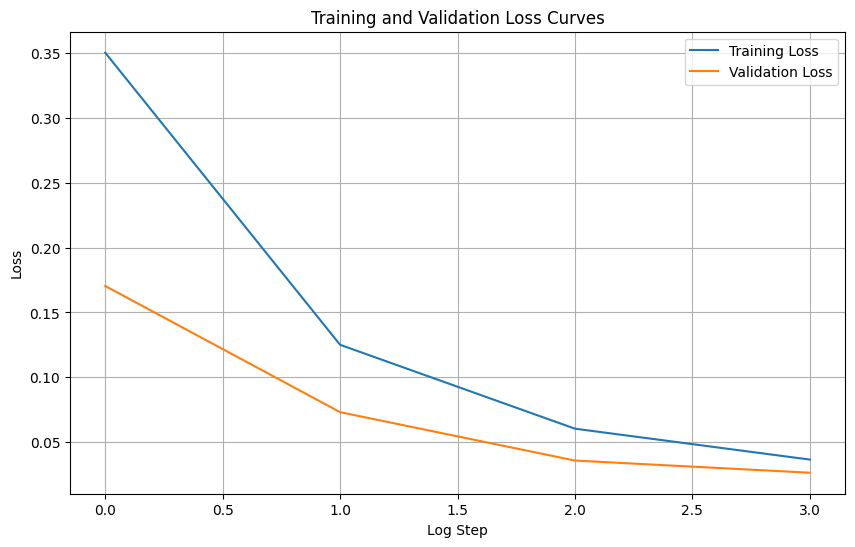

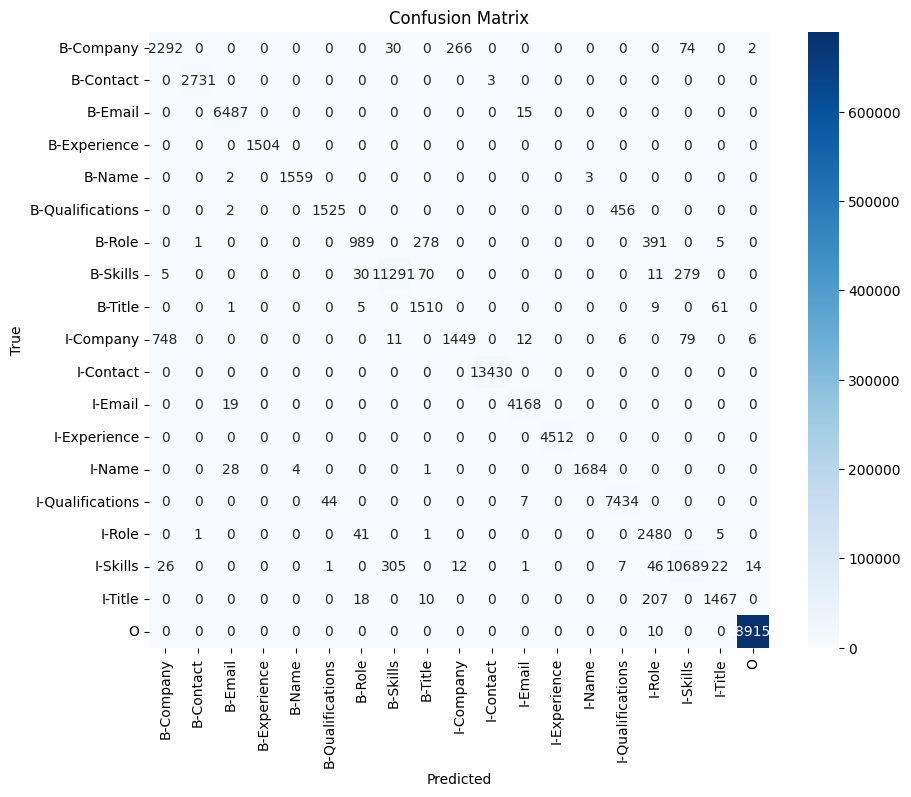

In [46]:
# After training, plot the loss curves
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Log Step')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot
plot_loss_curves(loss_callback.train_losses, loss_callback.val_losses)


# Predict on test dataset
predictions, labels, _ = trainer.predict(test_dataset)
preds = predictions.argmax(axis=2)  # Convert logits to predicted label IDs

# Convert IDs back to labels
true_labels = [[id_to_label[l] for l in label if l != -100] for label in labels]
true_predictions = [
    [id_to_label[p] for p, l in zip(prediction, label) if l != -100]
    for prediction, label in zip(preds, labels)
]

# Flatten lists for confusion matrix
flat_true = [item for sublist in true_labels for item in sublist]
flat_pred = [item for sublist in true_predictions for item in sublist]

# Generate and plot confusion matrix
def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels, labels=classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Get unique labels from data
unique_labels = sorted(list(set(flat_true + flat_pred)))

# Plot confusion matrix
plot_confusion_matrix(flat_true, flat_pred, classes=unique_labels)

**********************************

# Model Evaluation

Evaluate the model on the test set to measure its performance. Use metrics like F1-score, precision, and recall.

Cross-Entropy Loss

- Cross-entropy loss measures the difference between the predicted probability distribution and the true labels. In token classification tasks:

- The model outputs logits (unnormalized scores) for each token.
These logits are passed through a softmax function to produce probabilities.
- Cross-entropy loss is computed between the predicted probabilities and the ground-truth labels.
- cross-entropy loss is being logged during training and evaluation.

In [47]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00


In [48]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=ed650cde3a037412a6c9e512dc1d1c9d3db8c0dd252961ea64b4e99655465c1f
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [49]:
from seqeval.metrics import classification_report

# Predict on the test set
predictions, labels, _ = trainer.predict(test_dataset)  # Unpack all three values
preds = predictions.argmax(axis=2)  # Convert logits to predicted label IDs

# Convert IDs back to labels
true_labels = [[id_to_label[l] for l in label if l != -100] for label in labels]
true_predictions = [
    [id_to_label[p] for p, l in zip(prediction, label) if l != -100]
    for prediction, label in zip(preds, labels)
]

# Print the classification report
print(classification_report(true_labels, true_predictions))

                precision    recall  f1-score   support

       Company       0.55      0.67      0.60      2664
       Contact       1.00      1.00      1.00      2734
         Email       0.99      1.00      0.99      6502
    Experience       1.00      1.00      1.00      1504
          Name       0.96      0.98      0.97      1564
Qualifications       0.79      0.67      0.73      1983
          Role       0.60      0.63      0.62      1710
        Skills       0.92      0.92      0.92     11686
         Title       0.63      0.78      0.70      1649

     micro avg       0.87      0.89      0.88     31996
     macro avg       0.83      0.85      0.84     31996
  weighted avg       0.88      0.89      0.88     31996



In [50]:
# Evaluate the model on the test dataset
print("Evaluating on the test set...")
test_results = trainer.evaluate(test_dataset)

# Print the evaluation results
print(f"Test Loss (Cross-Entropy): {test_results['eval_loss']:.4f}")

Evaluating on the test set...


Validation Loss: 0.0271
Test Loss (Cross-Entropy): 0.0271


## Save the Model
- Once training is complete, save the fine-tuned model and tokenizer for inference.

In [51]:
# Save the model and tokenizer
model.save_pretrained('./ner_model')
tokenizer.save_pretrained('./ner_model')

('./ner_model/tokenizer_config.json',
 './ner_model/special_tokens_map.json',
 './ner_model/vocab.txt',
 './ner_model/added_tokens.json',
 './ner_model/tokenizer.json')

In [52]:
import shutil

# Define the folder path and output zip file name
folder_path = '/content/ner_model'
output_zip_name = '/content/ner_model_z.zip'

# Zip the folder
shutil.make_archive(output_zip_name.replace('.zip', ''), 'zip', folder_path)

print(f"Folder '{folder_path}' has been zipped to '{output_zip_name}'.")

Folder '/content/ner_model' has been zipped to '/content/ner_model_z.zip'.


save model to ner_model folder contents : config.json, model.safetensors, special_tokens_map.json, tokenizer.json, tokenizer_config.json, vocab.txt

In [ ]:
from google.colab import drive
import shutil

# Step 1: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
# Step 2: Define the source folder and destination path in Google Drive
source_folder = '/content/ner_model'
destination_folder = '/content/drive/MyDrive/ner_model_z'

# Step 3: Copy the folder to Google Drive
shutil.copytree(source_folder, destination_folder)

print(f"Folder '{source_folder}' has been uploaded to Google Drive at '{destination_folder}'.")

Folder '/content/ner_model' has been uploaded to Google Drive at '/content/drive/MyDrive/ner_model_z'.


How model.save_pretrained() Works:

This method saves:
- The model's architecture (structure).
- The model's learned weights (parameters).
- Additional metadata, such as the label mappings (id2label and label2id).

The saved files are typically stored in the specified directory (./ner_model in this case) and include:

- config.json: Contains the model's configuration (e.g., number of layers, hidden size, etc.).
- pytorch_model.bin: Contains the model's weights (learned parameters).
- tokenizer_config.json and vocab.txt: Contain the tokenizer's configuration and vocabulary.


**Importance of Saving the Tokenizer**

- Consistency: The tokenizer is responsible for converting raw text into tokens that the model understands. If you don't save the tokenizer alongside the model, you won't be able to preprocess new input data consistently.
- Tokenization Alignment: The tokenizer ensures that the tokenization process during inference matches the process used during training. This alignment is critical for accurate predictions.

How tokenizer.save_pretrained() Works:

This method saves:
- The tokenizer's vocabulary.
- Special tokens (e.g., [CLS], [SEP]).
- Tokenization rules (e.g., subword splitting logic).

The saved files are stored in the same directory (./ner_model) and include:

- tokenizer_config.json: Contains the tokenizer's configuration.
- vocab.txt (or similar): Contains the vocabulary used by the tokenizer.

## Use the Model for Inference
- Test the fine-tuned model to extract entities from new resumes.

In [56]:
!pip install PyPDF2 PyMuPDF

In [57]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import fitz  # PyMuPDF
import re

# Load trained model and tokenizer
model_path = "/content/ner_model"  # adjust if needed
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Read resume PDF
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    return " ".join([page.get_text() for page in doc])

# Clean ##subword tokens
def clean_tokens(tokens):
    words = []
    current = ""
    for token in tokens:
        token = token.replace("##", "")
        if current and not current.endswith(" "):
            current += token
        else:
            if current:
                words.append(current.strip())
            current = token
    if current:
        words.append(current.strip())
    return words

# Extract email and phone
def extract_email(text):
    match = re.search(r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+", text)
    return match.group() if match else None

def extract_phone(text):
    match = re.search(r"(\+?\d[\d\s\-()]{7,})", text)
    return match.group().strip() if match else None

# Split skills into list
def split_skills(text):
    parts = re.split(r",|\u2022|-|•", text)
    return list(set([p.strip().capitalize() for p in parts if len(p.strip()) > 2]))


# Run NER on text
def extract_entities_from_resume(pdf_path):
    text = extract_text_from_pdf(pdf_path)
    ner_results = ner_pipeline(text)

    entity_dict = {}
    for ent in ner_results:
        label = ent["entity_group"]
        word = ent["word"]
        entity_dict.setdefault(label, []).append(word)

    # Clean and join tokens for each entity
    cleaned_entities = {
        k: " ".join(clean_tokens(v)).replace(" .", ".").replace(" ,", ",").replace(" :", ":")
        for k, v in entity_dict.items()
    }

    # Postprocess contact info
    full_text = text
    cleaned_entities["Email"] = extract_email(full_text) or cleaned_entities.get("Email", None)
    cleaned_entities["Phone"] = extract_phone(full_text)

    # Normalize skills
    if "Skills" in cleaned_entities:
        cleaned_entities["Skills"] = split_skills(cleaned_entities["Skills"])

    # Ensure all entity types are present even if not detected
    required_entities = ["Name", "Title", "Role", "Contact", "Email", "Qualifications", "Experience", "Skills", "Company"]
    for entity in required_entities:
        if entity not in cleaned_entities:
            cleaned_entities[entity] = None  # or "" depending on preference

    return cleaned_entities


# Run inference
resume_path = "/content/Moses_Mugambi_Data_Scientist_CV.pdf"
result = extract_entities_from_resume(resume_path)

# Pretty print
import json
print(json.dumps(result, indent=2))

Device set to use cpu


{
  "Name": "moses mug",
  "Email": "mugambimoses2@gmail.com",
  "Title": "data scientist",
  "Role": "email",
  "Contact": ":+254718695260( 2024 - 2025 )",
  "Qualifications": "professional. b. sc.university of",
  "Skills": [
    "Anddata visualization toolstableaumatlibseaplotlybuildingive modelsimplementingp solutionsaboutleveragingdata sciencesolvereal",
    "Makingskilled in extracting meaningful insights fromcomplex datasetsdrivebusiness strategies and optimize processesinpython programmingsql",
    "Solvinganalytical thinkingcommunicationteamworkadaptability",
    "Based scientific calculator appinteractive graphical user interfaceeducation data science4presentrelevant courses and skillspython programmingmachine learningdata analysisdata storytellingdata visualizationweb scrapingsqlmodel / app deploymentelectrical and electronics engineeringtechnicalsecond upper classcoursesneural networksprobabilitystatisticslinear algebraeconomics skillspython programmingsscikit",
    "Driven

# Streamlit

In [ ]:
#!pip install streamlit transformers PyPDF2 scikit-learn

In [ ]:
'''
All entity-types are now included in the NER parsing.
Entities not detected will return None instead of being missing.
Improved UI to display all fields.
Added optional fallbacks for contact info using regex (if not found via NER).
Ensured compatibility with your DistilBERT NER model trained on these 9 entity types.
'''

import streamlit as st
import pandas as pd
import pdfplumber
from docx import Document
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import re
import os

# ✅ MUST BE THE FIRST STREAMLIT COMMAND
st.set_page_config(page_title="Resume Parsersing System", layout="wide")
# ✅ END OF FIRST COMMAND

# -----------------------------
# Load Model & Tokenizer
# -----------------------------
@st.cache_resource
def load_ner_pipeline():
    model_path = "ner_model_10pc"
    if not os.path.exists(model_path):
        st.error("Model not found. Please ensure the 'ner_model' folder exists.")
        return None
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForTokenClassification.from_pretrained(model_path)
        return pipeline(
            "ner",
            model=model,
            tokenizer=tokenizer,
            aggregation_strategy="simple"
        )
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None


ner_pipeline = load_ner_pipeline()

# -----------------------------
# File Reading Functions
# -----------------------------
def read_pdf(file):
    with pdfplumber.open(file) as pdf:
        text = ""
        for page in pdf.pages:
            text += page.extract_text() or ""
        return text


def read_docx(file):
    doc = Document(file)
    return "\n".join([para.text for para in doc.paragraphs])


def read_file(file):
    if file.type == "application/pdf":
        return read_pdf(file)
    elif file.type == "application/vnd.openxmlformats-officedocument.wordprocessingml.document":
        return read_docx(file)
    else:
        raise ValueError("Unsupported file format")


# -----------------------------
# Resume Parsing Function (Modified to include ALL entities)
# -----------------------------
def parse_resume(text):
    result = ner_pipeline(text)
    parsed = {
        "Name": [],
        "Title": [],
        "Role": [],
        "Contact": [],
        "Email": [],
        "Qualifications": [],
        "Experience": [],
        "Skills": [],
        "Company": []
    }
    for item in result:
        label = item['entity_group']
        word = item['word'].strip()
        if label in parsed:
            if word not in parsed[label]:
                parsed[label].append(word)

    # Optional fallbacks
    full_text = text
    if not parsed["Email"]:
        email = extract_email(full_text)
        if email:
            parsed["Email"] = [email]
    if not parsed["Contact"]:
        phone = extract_phone(full_text)
        if phone:
            parsed["Contact"] = [phone]

    return parsed


# -----------------------------
# Clean Tokens Helper
# -----------------------------
def clean_tokens(tokens):
    words = []
    current = ""
    for token in tokens:
        token = token.replace("##", "")
        if current and not current.endswith(" "):
            current += token
        else:
            if current:
                words.append(current.strip())
            current = token
    if current:
        words.append(current.strip())
    return words


# -----------------------------
# Extract Email & Phone
# -----------------------------
def extract_email(text):
    match = re.search(r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+", text)
    return match.group() if match else None


def extract_phone(text):
    match = re.search(r"(\+?\d[\d\s\-()]{7,})", text)
    return match.group().strip() if match else None


# -----------------------------
# Normalize Skills
# -----------------------------
def split_skills(text):
    parts = re.split(r",|\u2022|-|•", text)
    return list(set([p.strip().capitalize() for p in parts if len(p.strip()) > 2]))


# -----------------------------
# Match Against Job Description
# -----------------------------
def compute_match_score(resume_text, job_desc):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([resume_text, job_desc])
    return cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]


def compare_resume_to_job(parsed_resume, job_desc):
    resume_text = " ".join([
        " ".join(parsed_resume["Skills"]),
        " ".join(parsed_resume["Experience"]),
        " ".join(parsed_resume["Qualifications"])
    ])
    job_desc_lower = job_desc.lower()
    matched_skills = [skill for skill in parsed_resume["Skills"] if skill.lower() in job_desc_lower]
    missing_skills = [skill for skill in parsed_resume["Skills"] if skill.lower() not in job_desc_lower]
    score = compute_match_score(resume_text, job_desc)
    return {
        "score": round(score * 100, 2),
        "matched_skills": matched_skills,
        "missing_skills": missing_skills
    }


# -----------------------------
# Highlight Matching Keywords
# -----------------------------
def highlight_keywords(text, keywords, color="yellow"):
    for keyword in keywords:
        pattern = re.compile(re.escape(keyword), re.IGNORECASE)
        text = pattern.sub(f'<mark style="background-color:{color}">{keyword}</mark>', text)
    return text


# -----------------------------
# Batch Processing Function
# -----------------------------
def batch_process_resumes(files, job_description):
    results = []
    for file in files:
        try:
            resume_text = read_file(file)
            parsed = parse_resume(resume_text)
            comparison = compare_resume_to_job(parsed, job_description)
            results.append({
                "filename": file.name,
                "score": comparison["score"],
                "parsed": parsed,
                "comparison": comparison,
                "text": resume_text
            })
        except Exception as e:
            results.append({"filename": file.name, "error": str(e)})
    return sorted(results, key=lambda x: x.get("score", 0), reverse=True)


# -----------------------------
# Analytics Dashboard
# -----------------------------
def show_analytics_dashboard(results):
    st.header("📊 Analytics Dashboard")
    df_scores = pd.DataFrame([{k: v for k, v in res.items() if k in ['filename', 'score']} for res in results if "error" not in res])
    st.subheader("🏆 Ranked Resumes by Match Score:")
    st.dataframe(df_scores.style.background_gradient(cmap='Blues', subset=["score"]))

    all_skills = []
    for res in results:
        if "error" not in res:
            all_skills.extend(res["parsed"]["Skills"])

    from collections import Counter
    skill_counter = Counter(all_skills)
    skill_df = pd.DataFrame(skill_counter.most_common(10), columns=["Skill", "Count"])
    st.subheader("🔥 Top Skills Across All Resumes")
    st.bar_chart(skill_df.set_index('Skill'))


# -----------------------------
# Streamlit UI
# -----------------------------
def main():
    # Custom CSS
    st.markdown("""
    <style>
    body { font-family: Arial; }
    h1 { color: #2C3E50; }
    .stButton>button { background-color: #2980B9; color: white; border-radius: 6px; }
    mark { padding: 2px 4px; border-radius: 4px; }
    </style>
    """, unsafe_allow_html=True)

    # Logo
    try:
        logo = Image.open("logo.png")
        st.image(logo, width=200)
    except FileNotFoundError:
        st.warning("No logo found. Add 'logo.png' for branding.")

    st.title("📄 Resume Parser & Job Matcher")
    st.markdown("Upload resumes and compare them with a job description. Get match scores, skill analysis, and ranked list.")

    tab1, tab2, tab3 = st.tabs(["🔍 Single Resume Analysis", "📂 Batch Resume Ranking", "📈 Analytics Dashboard"])

    # --- Tab 1: Single Resume ---
    with tab1:
        uploaded_file = st.file_uploader("Upload your resume (.pdf or .docx)", type=["pdf", "docx"], key="single_upload")
        job_description = st.text_area("Enter job description", height=200)
        if st.button("🔍 Analyze Resume") and uploaded_file and job_description:
            with st.spinner("Parsing resume..."):
                resume_text = read_file(uploaded_file)
                parsed = parse_resume(resume_text)
                comparison = compare_resume_to_job(parsed, job_description)

                st.subheader("📊 Match Analysis")
                st.write(f"**Match Score:** {comparison['score']}%")

                col1, col2 = st.columns(2)
                with col1:
                    st.markdown("✅ **Matching Skills**")
                    st.write(", ".join(comparison['matched_skills']) or "None")
                with col2:
                    st.markdown("❌ **Missing Skills**")
                    st.write(", ".join(comparison['missing_skills']) or "None")

                st.markdown("📌 **Parsed Resume Info**")
                st.json({
                    key: " | ".join(value) if isinstance(value, list) else value
                    for key, value in parsed.items()
                })

                st.markdown("📝 **Highlighted Resume**")
                highlighted_resume = highlight_keywords(resume_text, comparison['matched_skills'], "lightgreen")
                highlighted_resume = highlight_keywords(highlighted_resume, comparison['missing_skills'], "lightcoral")
                st.markdown(highlighted_resume, unsafe_allow_html=True)

    # --- Tab 2: Batch Mode ---
    with tab2:
        st.header("📥 Batch Resume Matching (HR)")
        job_desc_batch = st.text_area("Job Description for Batch", height=150)
        batch_files = st.file_uploader("Upload multiple resumes", type=["pdf", "docx"], accept_multiple_files=True)
        if st.button("🏆 Rank Resumes") and job_desc_batch and batch_files:
            with st.spinner("Processing resumes..."):
                batch_results = batch_process_resumes(batch_files, job_desc_batch)
                st.subheader("🏆 Ranked Resumes by Match Score:")
                df_ranked = pd.DataFrame([{
                    "Filename": res["filename"],
                    "Score (%)": res["score"]
                } for res in batch_results if "error" not in res])
                st.dataframe(df_ranked.style.background_gradient(cmap='Blues', subset=["Score (%)"]))
                for res in batch_results:
                    if "error" in res:
                        st.error(f"{res['filename']}: {res['error']}")

    # --- Tab 3: Analytics Dashboard ---
    with tab3:
        st.header("📈 Analytics Dashboard")
        job_desc_analytics = st.text_area("Enter job description for analytics", height=150)
        analytics_files = st.file_uploader("Upload resumes for analytics", type=["pdf", "docx"], accept_multiple_files=True)
        if st.button("📊 Generate Analytics") and analytics_files and job_desc_analytics:
            with st.spinner("Analyzing resumes..."):
                analytics_results = batch_process_resumes(analytics_files, job_desc_analytics)
                show_analytics_dashboard(analytics_results)


if __name__ == "__main__":
    main()

Explanation of Features

**1. Single Resume Parsing**
File Upload: Users can upload a single PDF resume.
Job Description Input: Users provide a job description in a text box.
Output:
Extracted Resume Text: Displays the raw text extracted from the resume.
Extracted Entities: Lists all named entities (e.g., Name, Title, Skills) captured by the NER model.
Matching Skills: Highlights skills in the resume that match the job description.
Missing Skills: Lists skills mentioned in the job description but missing from the resume.
Resume Score: Provides a similarity score (percentage) between the resume and job description.

**2. Batch Resume Ranking**
File Upload: Users can upload multiple PDF resumes.
Job Description Input: Users provide a job description in a text box.

Output:
Ranked Resumes: Displays a ranked list of resumes based on their similarity scores with the job description.